# Single-cell RNA-seq analysis workflow for 1.3 M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

import os, wget

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc._settings.ScanpyConfig.n_jobs = 40

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

CPU times: user 1min 10s, sys: 8.78 s, total: 1min 19s
Wall time: 1min 19s


(1306127, 27998)

In [6]:
# To reduce the number of cells: 

USE_FIRST_N_CELLS = 50000
adata = adata[0:USE_FIRST_N_CELLS]
adata.shape

(50000, 27998)

## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 7.93 s, sys: 2.84 s, total: 10.8 s
Wall time: 10.8 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 1.07 s, sys: 572 ms, total: 1.65 s
Wall time: 1.64 s


In [10]:
adata.shape

(49548, 20952)

### Normalize

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 372 ms, sys: 88 ms, total: 460 ms
Wall time: 459 ms


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 1.16 s, sys: 194 µs, total: 1.16 s
Wall time: 1.16 s


### Select Most Variable Genes

In [13]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].toarray().ravel()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.83 s, sys: 151 ms, total: 1.98 s
Wall time: 2.06 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

CPU times: user 708 ms, sys: 48.1 ms, total: 756 ms
Wall time: 755 ms


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 8.54 s, sys: 5.78 s, total: 14.3 s
Wall time: 23.3 s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.45 s, sys: 199 ms, total: 1.65 s
Wall time: 1.65 s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 41.82338070869446


## Cluster & Visualize

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [18]:
%%time
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 7min 30s, sys: 48 s, total: 8min 18s
Wall time: 7.63 s


### TSNE + K-means

In [19]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, use_fast_tsne=True)

CPU times: user 11min 3s, sys: 1.47 s, total: 11min 4s
Wall time: 1min 58s


In [20]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 11min 12s, sys: 6min 14s, total: 17min 26s
Wall time: 16.2 s


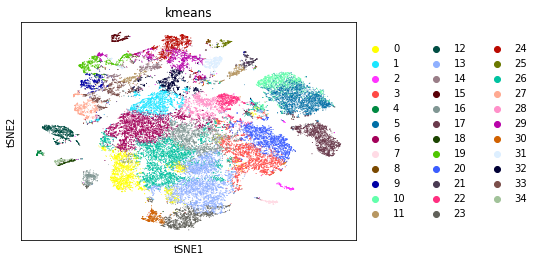

CPU times: user 1.01 s, sys: 240 ms, total: 1.25 s
Wall time: 1.01 s


In [21]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

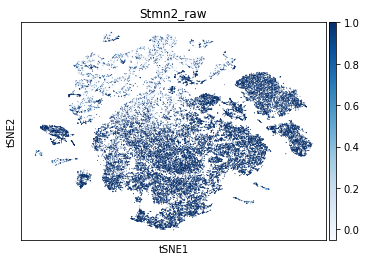

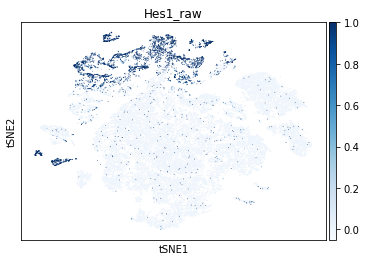

CPU times: user 742 ms, sys: 236 ms, total: 977 ms
Wall time: 485 ms


In [22]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

In [23]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 47.6 s, sys: 33.9 s, total: 1min 21s
Wall time: 16 s


In [24]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 4min 53s, sys: 3min 19s, total: 8min 13s
Wall time: 48.6 s


In [25]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 8.14 s, sys: 126 ms, total: 8.26 s
Wall time: 8.25 s


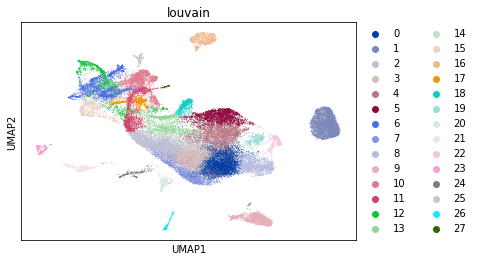

CPU times: user 902 ms, sys: 174 ms, total: 1.08 s
Wall time: 829 ms


In [26]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [27]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 11.6 s, sys: 111 ms, total: 11.7 s
Wall time: 11.7 s


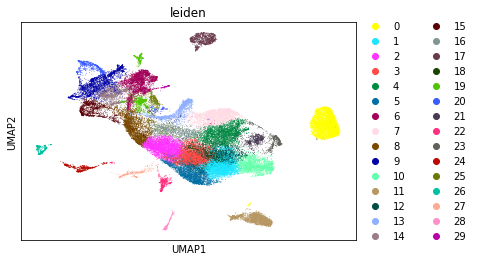

CPU times: user 912 ms, sys: 201 ms, total: 1.11 s
Wall time: 866 ms


In [28]:
%%time
sc.pl.umap(adata, color=["leiden"])

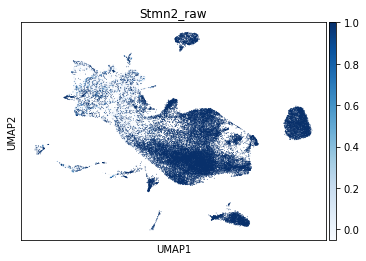

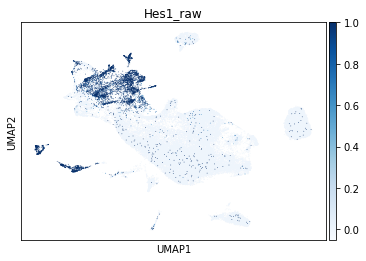

CPU times: user 721 ms, sys: 235 ms, total: 956 ms
Wall time: 465 ms


In [29]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Differential expression analysis

In [30]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=50, groups='all', reference='rest', method='logreg')

CPU times: user 49min 17s, sys: 17min 19s, total: 1h 6min 36s
Wall time: 52.4 s


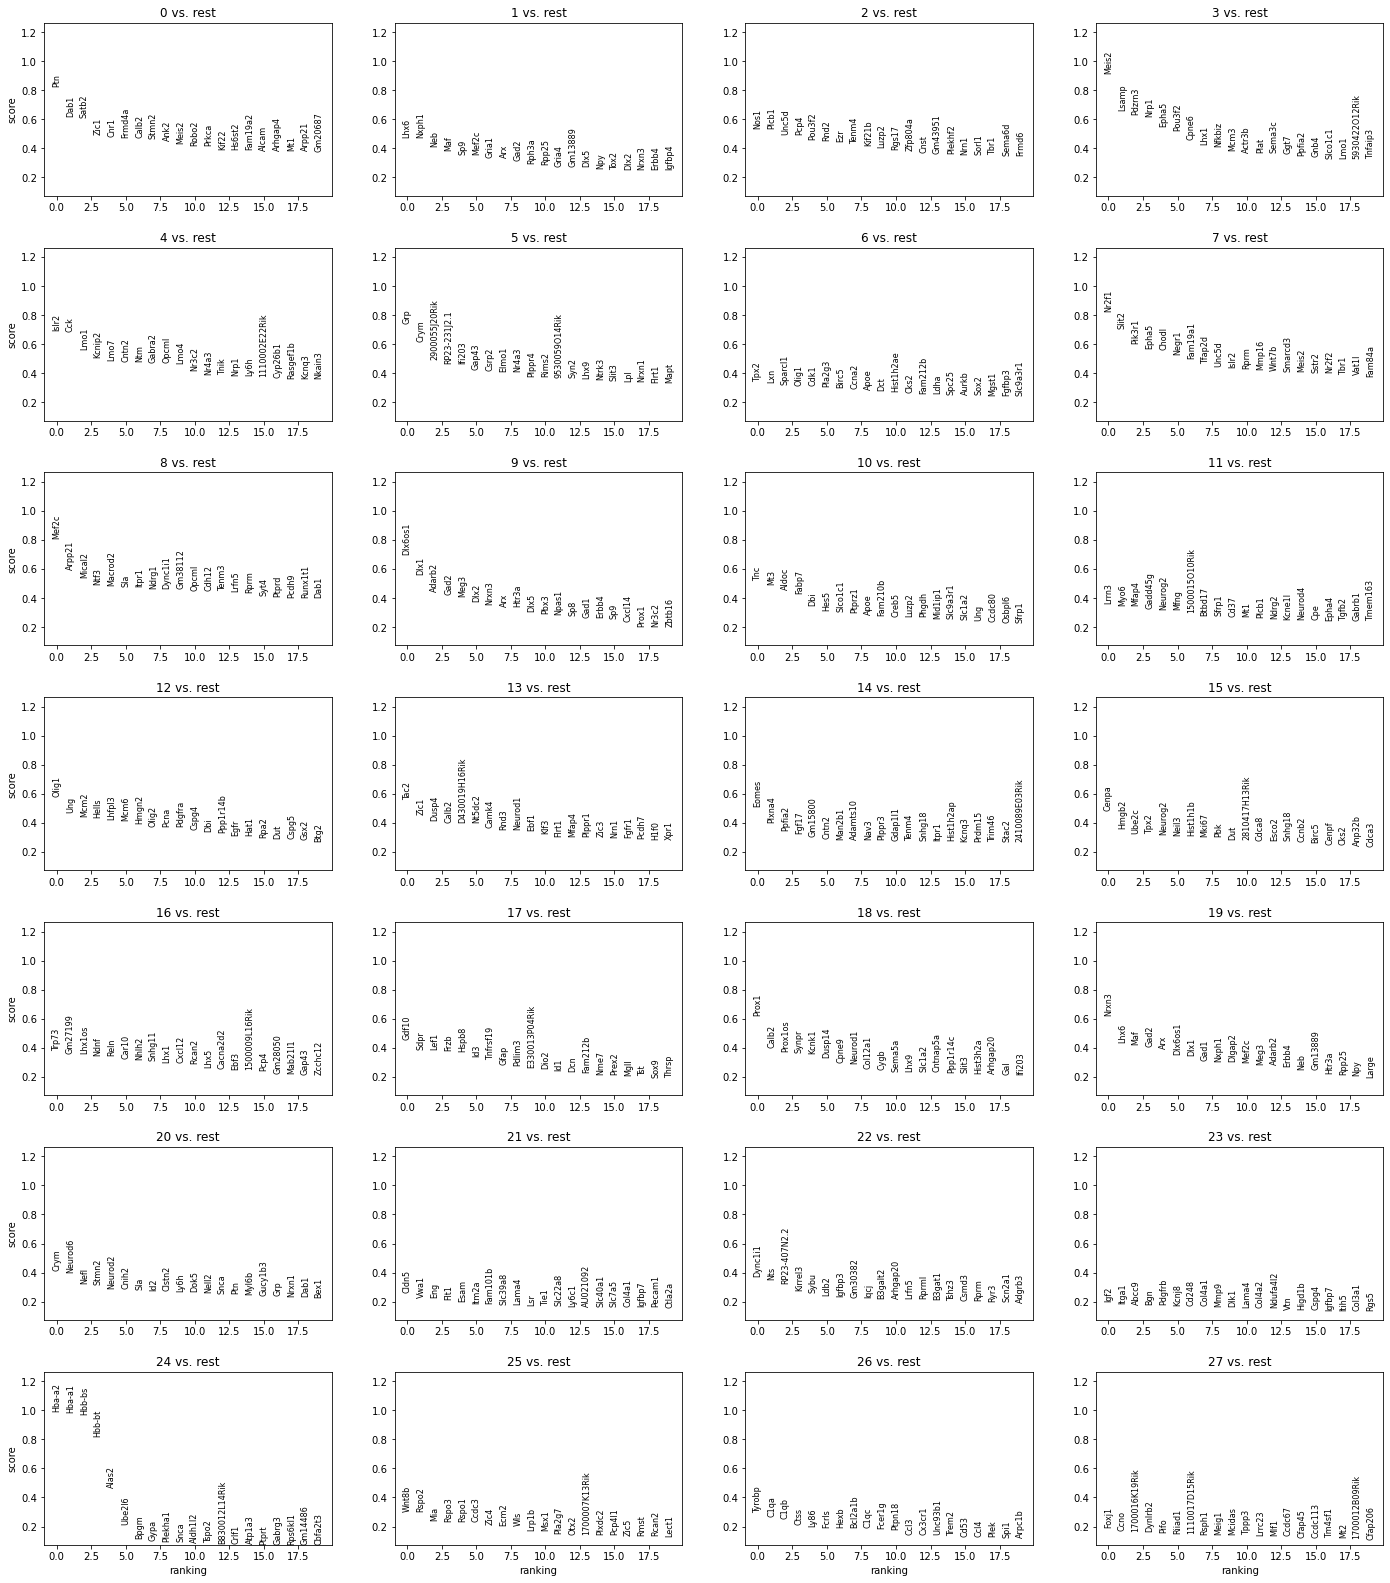

CPU times: user 4.46 s, sys: 2.57 s, total: 7.02 s
Wall time: 6.78 s


In [31]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [32]:
print("Full time: %s" % (time.time() - start))

Full time: 411.3785789012909


In [33]:
adata.write("1M_cells_50k_cpu.h5py")